# Predição de Consumo

Este notebook demonstra o uso do modelo ARIMA para realizar predições de consumo a partir das informações disponíveis nos data sets REDD e Smart*.

São realizadas as seguintes predições:

1. Predição por meio da biblioteca statsmodels
2. Predição diária, por meio da biblioteca pmdarima
3. Predição mensal, por meio da biblioteca pmdarima

In [1]:
import csv
import datetime
import operator
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import load_house

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

# Create directory for matplotlib figures
if not os.path.exists('plot/ARIMA'):
    os.makedirs('plot/ARIMA')

# Carregando dados de consumo

A cédula a seguir carrega dados de 2015 e 2016 do data set Smart.

In [2]:
#channels, labels = REDD(1)
channels1, labels = load_house.SMART('2015')
channels2, labels = load_house.SMART('2016')
channels = channels1.copy()
for i in range(len(channels)):
    channels[i] = channels[i].append(channels2[i], ignore_index=True)

# Escolhendo período e granularidade da predição e base de testes

É possível escolher o período da base de testes por meio de `test_start` e `test_end`, o número de períodos preditos por `periods_predicted`, e a granularidade por `test_frequency`.

In [3]:
def get_aggr_cons(start, end, frequency):
    """Runs a query for the aggregated consumption in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    periods = (pd.to_datetime(end) - pd.to_datetime(start)).days
    if frequency == 'W':
        periods /= 7
    if frequency == 'M':
        periods /= 30
    t = pd.date_range(start, periods=periods, freq=frequency)
    energy = pd.DataFrame(0, index=np.arange(periods), columns=['energy'])
    aggr_cons = pd.DataFrame([t, energy]).transpose()
    aggr_cons.columns = ['t', 'energy']
    aggr_cons.t = pd.to_datetime(aggr_cons.t)
    aggr_cons.energy = 0
    
    for i in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask].copy()

        # Find mean consumption by day, week, or month
        cons = ch_period.copy()
        cons = cons.set_index('t')
        cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
        cons = cons.reset_index()
        cons = pd.concat([cons.t, cons.pot], axis=1)
        cons.columns = ['t', 'energy']

        # Remove days without consumption data
        cons = cons[~cons.energy.isna()]

        # Convert to kWh
        period_hours = 24
        if frequency == 'W':
            period_hours *= 7
        if frequency == 'M':
            period_hours *= 30
        cons.energy = cons.energy * period_hours / 1e3
        
        aggr_cons['energy'] += cons.energy
    
    #aggr_cons.ix[151, 'energy'] = 0
    #aggr_cons.at[151, 'energy'] = 0
    aggr_cons.t = aggr_cons.t.dt.date
    '''if frequency == 'D':
        test.at[151, 'energy'] = 0
        test.at[154, 'energy'] = 0
    if frequency == 'W':
        test.at[22, 'energy'] = 0
    if frequency == 'M':
        test.at[5, 'energy'] = 0
    '''
    return aggr_cons


# ARMA and ARIMA forecast
periods_predicted = 30
test_frequency = 'D'
test_start = '2016-01-01'
test_end = '2016-06-01'

# Get test data
test = get_aggr_cons(test_start, test_end, test_frequency)

# Get validation data
days_predicted = periods_predicted
days_delta = 1
if test_frequency == 'W':
    days_delta = 7
elif test_frequency == 'M':
    days_delta = 30

validation_start = test.t.iloc[-1] + datetime.timedelta(days=days_delta)
validation_end = validation_start + datetime.timedelta(days=days_delta*periods_predicted)
validation = get_aggr_cons(validation_start, validation_end, test_frequency)

# Predição por meio da biblioteca statsmodels

As cédulas a seguir demonstram o uso da biblioteca statsmodels para realizar a predição diária, semanal, e mensal do consumo no ano de 2016 do data set Smart.

A biblioteca possui a classe `statsmodels.tsa.arima_model.ARIMA`, a qual permite escolher os parâmetros e realizar predição de modelos ARIMA.

/home/tiago/anaconda3/envs/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


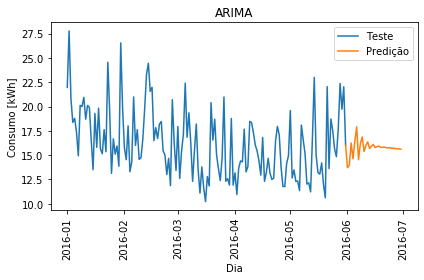

In [4]:
def qry_ARIMA(days_predicted, pdq):
    """Runs a query for the forecast consumption using an ARIMA model.
    
    Args:
        days_predicted (int): number of days to forecast.
        pdq (iterable): order of the model parameters.
    
    Returns:
        str: csv of the query as [index, date, daily forecasted consumption].
    """
    model = ARIMA(test.energy, pdq)
    model_fit = model.fit(disp=0)
    predicted = model_fit.forecast(days_predicted)
    
    # Add daily consumption of current day
    predict_cons = np.insert(predicted[0], 0, test.energy.iloc[-1])
    
    # Convert to pandas.DataFrame
    result = pd.DataFrame(np.transpose([np.insert(validation.t.values, 0, test.t.iloc[-1]), predict_cons]))
    result.columns = ['t', 'energy']
    
    return result.to_csv()


# Plot forecast for 30 days aggregated consumption with ARIMA
query = qry_ARIMA(days_predicted, (3, 1, 7))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARIMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arima.png')

/home/tiago/anaconda3/envs/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


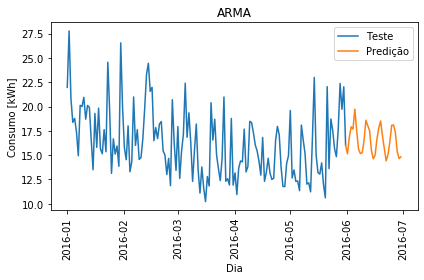

In [5]:
query = qry_ARIMA(days_predicted, (8, 0, 7))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arma.png')

# Predição por meio da biblioteca pmdarima

A biblioteca pmdarima permite realizar o ajuste automático dos parâmetros e da sazonalidade, escolhendo aquele que possui o menor AIC.

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=733.173, BIC=745.052, Fit time=0.490 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=830.062, BIC=836.002, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=778.518, BIC=790.398, Fit time=0.146 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=713.795, BIC=725.674, Fit time=0.447 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=715.695, BIC=730.544, Fit time=0.765 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=792.638, BIC=801.548, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=715.683, BIC=730.532, Fit time=1.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=709.734, BIC=727.553, Fit time=1.275 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=708.696, BIC=729.484, Fit time=1.608 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 7);

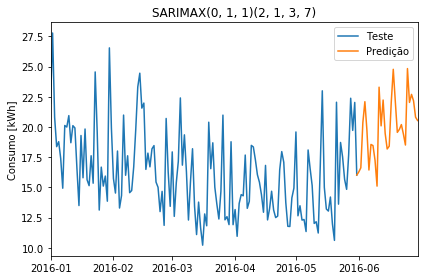

In [6]:
seasonal = True
season_period = 7
periods_predicted = 30
test_frequency = 'D'
test_start = '2016-01-01'
test_end = '2016-06-01'

test = get_aggr_cons(test_start, test_end, test_frequency)

# Get validation data
days_predicted = periods_predicted
days_delta = 1

validation_start = test.t.iloc[-1] + datetime.timedelta(days=days_delta)
validation_end = validation_start + datetime.timedelta(days=days_delta*periods_predicted)
validation = get_aggr_cons(validation_start, validation_end, test_frequency)

stepwise_fit = auto_arima(test.energy, start_p=1, start_q=0, max_p=10, max_q=10, m=season_period,
                          start_P=0, max_P=10, max_Q=10, seasonal=seasonal, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

predicted = stepwise_fit.predict(n_periods=periods_predicted)

plt.plot(test.t.values, test.energy.values)
plt.plot(np.insert(validation.t.values, 0, test.t.iloc[-1]), np.insert(predicted, 0, test.energy.iloc[-1]))
#plt.plot(validation.t.values, validation.energy.values)

params = stepwise_fit.get_params()
title = 'SARIMAX{}{}'.format(params['order'], params['seasonal_order'])
plt.title(title)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.margins(x=0)
plt.savefig('plot/ARIMA/auto-arima.png')

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=23.442, BIC=20.828, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=0.008 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.021 seconds


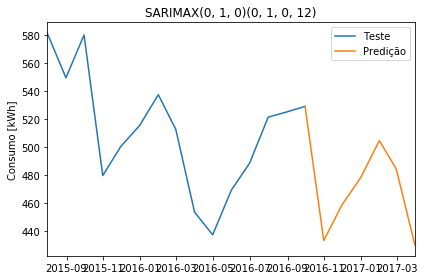

In [7]:
seasonal = True
season_period = 12
periods_predicted = 6
test_frequency = 'M'
test_start = '2015-07-01'
test_end = '2016-10-01'

test = get_aggr_cons(test_start, test_end, test_frequency)

# Get validation data
days_predicted = 30 * periods_predicted

validation_start = test.t.iloc[-1] + datetime.timedelta(days=30)
validation_end = validation_start + datetime.timedelta(days=days_predicted)
validation = get_aggr_cons(validation_start, validation_end, test_frequency)

stepwise_fit = auto_arima(test.energy, start_p=1, start_q=1, max_p=10, max_q=10, m=season_period,
                          start_P=0, max_P=10, max_Q=10, seasonal=seasonal, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

predicted = stepwise_fit.predict(n_periods=periods_predicted)

plt.plot(test.t.values, test.energy.values)
plt.plot(np.insert(validation.t.values, 0, test.t.iloc[-1]), np.insert(predicted, 0, test.energy.iloc[-1]))
#plt.plot(validation.t.values, validation.energy.values)

params = stepwise_fit.get_params()
title = 'SARIMAX{}{}'.format(params['order'], params['seasonal_order'])
plt.title(title)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.margins(x=0)
plt.savefig('plot/ARIMA/auto-arima.png')